#Data Processing
We want to obtain records relevant to making outcome predictions based on chemotherapy treatment. We utilize lifestyle, family history, medical/surgical history, signs and symptoms, comobidites, laboratory values, pathology, age, pharmacological therapy, diagnosis, and patient outcome assessment.

In [1]:
import pandas as pd
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Define a function to filter out non-chemotherapy cases and those without patient outcomes
#Exploratory analysis to find specific cases that match our needs
def convert_tsv_to_json_csv(input_filepath, output_filepath_json, output_filepath_csv):
    # We retain attributes possibly important to determine response to chemotherapy
    attrs_cols = [
        'CR Number', 'Life Style', 'Family History',
        'Medical/Surgical History', 'Signs and Symptoms',
        'Comorbidities', 'Diagnosis', 'Laboratory Values', 'Pathology', 'Age',
        'Pharmacological Therapy', 'Interventional Therapy', 'Patient Outcome Assessment'
    ]

    # Read the TSV file and filter the required columns
    df = pd.read_csv(input_filepath, sep='\t', usecols=attrs_cols)

    # Subsetting patients who have recieved chemotherapy as a Pharmacological Therapy
    df = df[df['Pharmacological Therapy'].str.contains("chemotherapy", na = False)]
    # Subsetting patients who have a listed outcome (Not "NA")
    df = df[df['Patient Outcome Assessment'].notnull()]

    # Save the filtered data to a JSON file to parse
    df.to_json(output_filepath_json, orient='records', indent=2)

    # Save the filted data to csv to view for samples of interest
    df.to_csv(output_filepath_csv)

convert_tsv_to_json_csv('/content/drive/MyDrive/BIOINFO 201/Project_W25/MACCRs.tsv',
                    '/content/drive/MyDrive/BIOINFO 201/Project_W25/MACCRs_chemo.json',
                    '/content/drive/MyDrive/BIOINFO 201/Project_W25/MACCRs_chemo.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Defining a function to extract patient specific JSONs for COT reasoning
def patient_specific_json(input_filepath, case_number_list):
    attrs_cols = [
      'CR Number', 'Life Style', 'Family History',
      'Medical/Surgical History', 'Signs and Symptoms',
      'Comorbidities', 'Diagnosis', 'Laboratory Values', 'Pathology', 'Age',
      'Pharmacological Therapy', 'Interventional Therapy', 'Patient Outcome Assessment'
    ]

    # Read the TSV file and filter the required columns
    df = pd.read_csv(input_filepath, sep='\t', usecols = attrs_cols)
    df = df[df['CR Number'].isin(case_number_list)]

    # Save the filtered data to a JSON file to parse
    df.to_json(f"/content/drive/MyDrive/BIOINFO 201/Project_W25/MACCRs_chemo_specific.json", orient='records', indent=2)

#Creating our patient specific JSONs
#Case Number CCR1393 and CCR2655
patient_specific_json('/content/drive/MyDrive/BIOINFO 201/Project_W25/MACCRs.tsv', case_number_list = ["CCR1393", "CCR2655"])


#Logging into Hugging Face

In [ ]:
from huggingface_hub import login
with open("/content/drive/MyDrive/BIOINFO 201/Project_W25/hugging_face_access_token.txt", "r") as file:
    access_token = file.read().strip()
login(access_token)
print("Logged in successfully!")

Logged in successfully!


#Loading Hugging Face Models and Making Predictions

We choose our LLM models: Google's Gemma 2 Instruct with 1 billion parameters and Llama 3.2 Instruct with 3 billion parameters.

We load one at a time since loading both models require a lot of memory.



In [ ]:
import json
import random
import pandas as pd
import argparse
from tqdm import tqdm
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import csv
from google.colab import drive

#Function to load json from data processing step
def load_dataset_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

#Formatting the case to extract cr_number, case description, and patient outcome/
#response to chemotherapy
def format_case(patient_case):
    attrs_cols = [
        'Life Style',
        'Family History',
        'Medical/Surgical History',
        'Signs and Symptoms',
        'Comorbidities',
        'Diagnosis',
        'Laboratory Values',
        'Pathology',
        'Age',
        'Interventional Therapy',
        'Pharmacological Therapy'
    ]

    cr_number = patient_case.get('CR Number', 'NA') if patient_case.get('CR Number') is not None else 'NA'
    descriptions = "; ".join(f"{col}: {patient_case.get(col, 'NA') if patient_case.get(col) is not None else 'NA'}" for col in attrs_cols)
    #Get actual patient outcome to compare with LLM reponse
    outcome = patient_case.get('Patient Outcome Assessment', 'NA') if patient_case.get('Patient Outcome Assessment') is not None else 'NA'

    return cr_number, descriptions, outcome

#Defining a function to prompt the model for a response
def pred_zeroshot(case_description, model, tokenizer, device):
    #Curating a prompt where the model is a skilled oncologist that can predict patient outlook
    prompt = f"""You are a highly knowledgeable oncologist with expertise in treating cancer \
    and providing chemotherapy. You are presented with a patient's clinical details and \
    are asked to provide a prediction on the patient's outlook in response to chemotherapy. \
    For a clinical case like this: {case_description}\n, what is the patient's outlook in response to chemotherapy? \
    Please provide the potential patient outlook in response to chemotherapy, and limit your response to a maximum of 10 words. Be very clear and concise in your prediction."""

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs['input_ids']

    input_token_length = input_ids.shape[1]
    output_ids = model.generate(input_ids, max_new_tokens=128, do_sample=False)
    output = tokenizer.decode(output_ids[0][input_token_length:])
    outcome = output.replace('\n', '').strip()

    del inputs
    del output

    return outcome

def pred_zeroshot_cot(case_description, model, tokenizer, device):
    #Curating a prompt where the model is a skilled oncologist that can predict patient outlook
    #We add a zero-shot chain of thought (COT) prompt to analyze LLM motivations
    #The prompt is "Let's think about it step by step."
    prompt = f"""You are a highly knowledgeable oncologist with expertise in treating cancer \
    and providing chemotherapy. You are presented with a patient's clinical details and \
    are asked to provide a prediction on the patient's outlook in response to chemotherapy. \
    For a clinical case like this: {case_description}\n, what is the patient's outlook in response to chemotherapy? \
    Let's think about it step by step.\
    Please provide the potential patient outlook in response to chemotherapy. \
    Limit your response to a maximum of 150 words. Be very clear and concise in your reasoning."""

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs['input_ids']

    input_token_length = input_ids.shape[1]
    output_ids = model.generate(input_ids, max_new_tokens=512, do_sample=False)
    output = tokenizer.decode(output_ids[0][input_token_length:])
    outcome = output.replace('\n', '').strip()

    del inputs
    del output

    return outcome


def main(args_model, y_attr):
    model_name = args_model.split("/")[-1]
    dataset = load_dataset_json('/content/drive/MyDrive/BIOINFO 201/Project_W25/MACCRs_chemo.json')
    dataset_cot = load_dataset_json('/content/drive/MyDrive/BIOINFO 201/Project_W25/MACCRs_chemo_specific.json')

    results_fp = f'/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_{model_name}.csv'
    results_fp_cot = f'/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_{model_name}_cot.csv'

    tokenizer = AutoTokenizer.from_pretrained(args_model, device_map="auto", return_tensors="pt", use_fast=False)
    model = AutoModelForCausalLM.from_pretrained(args_model, device_map="auto", torch_dtype=torch.float16)
    device = model.device

    #Writing results for COT prompting
    with open(results_fp_cot, 'a', newline='') as csvfile:
      csvwriter = csv.writer(csvfile)

      if csvfile.tell() == 0:
          csvwriter.writerow(['cr_number', f'actual_{y_attr.replace(" ", "_")}',
                              f'pred_{y_attr.replace(" ", "_")}_{model_name}'])  # Adjust columns as needed

      for i, patient_case in tqdm(enumerate(dataset_cot)):
          cr_number, descriptions, outcome = format_case(patient_case)
          pred = pred_zeroshot_cot(descriptions, model, tokenizer, device)
          csvwriter.writerow([cr_number, outcome, pred])

    #Writing results for all patients who have undergone chemotherapy
    with open(results_fp, 'a', newline='') as csvfile:
      csvwriter = csv.writer(csvfile)

      if csvfile.tell() == 0:
          csvwriter.writerow(['cr_number', f'actual_{y_attr.replace(" ", "_")}',
                              f'pred_{y_attr.replace(" ", "_")}_{model_name}'])  # Adjust columns as needed

      for i, patient_case in tqdm(enumerate(dataset)):
          cr_number, descriptions, outcome = format_case(patient_case)
          pred = pred_zeroshot(descriptions, model, tokenizer, device)
          csvwriter.writerow([cr_number, outcome, pred])

#Our model of choices are "meta-llama/Llama-3.2-3B-Instruct" or
#"google/gemma-2-2b-it" or
#"microsoft/Phi-4-mini-instruct"

if __name__ == "__main__":
    main("microsoft/Phi-4-mini-instruct", "Patient Outcome Assessment")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

0it [00:00, ?it/s]The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
2it [00:28, 14.42s/it]
185it [05:00,  1.62s/it]


#Evaluation of Models using Cosine Similarity

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pandas as pd


def get_embedding_bert(text, bert_model):
    return bert_model.encode([text])

#we use cosine similarity, and a bert model for embeddings
def cal_similarity(text1, text2, client):
    emb1 = get_embedding_bert(str(text1), client)  # Convert to string
    emb2 = get_embedding_bert(str(text2), client)  # Convert to string
    cos_similarity = cosine_similarity(emb1, emb2)[0][0]

    #Adding L1 and L2 distances between vectors
    L1_dist = np.linalg.norm(emb1 - emb2, ord = 1)
    L2_dist = np.linalg.norm(emb1 - emb2, ord = 2)
    return cos_similarity, L1_dist, L2_dist

def evaluate(path, gt_column_name, pred_column_name):
    # Read the CSV file
    df = pd.read_csv(path)

    # Create BERT client
    client = SentenceTransformer('bert-base-nli-mean-tokens')

    gts = df[gt_column_name]
    preds = df[pred_column_name]

    # Compute cosine similarity for each row
    results_cos = []
    results_L1 = []
    results_L2 = []
    for i, gt in tqdm(enumerate(gts)):
        pred = preds[i]
        cos_similarity, L1_dist, L2_dist = cal_similarity(gt, pred, client)
        results_cos.append(cos_similarity)
        results_L1.append(L1_dist)
        results_L2.append(L2_dist)
    df["cosine_similarity"] = results_cos
    df["L1_distance"] = results_L1
    df["L2_distance"] = results_L2
    df.to_csv(path, index=False)

In [3]:
evaluate("/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Llama-3.2-3B-Instruct.csv",
         "actual_Patient_Outcome_Assessment",
         "pred_Patient_Outcome_Assessment_Llama-3.2-3B-Instruct")
evaluate("/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_gemma-2-2b-it.csv",
         "actual_Patient_Outcome_Assessment",
         "pred_Patient_Outcome_Assessment_gemma-2-2b-it")
evaluate("/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Phi-4-mini-instruct.csv",
         "actual_Patient_Outcome_Assessment",
         "pred_Patient_Outcome_Assessment_Phi-4-mini-instruct")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

185it [00:50,  3.64it/s]
185it [00:43,  4.29it/s]
185it [00:49,  3.71it/s]


#Plotting the data

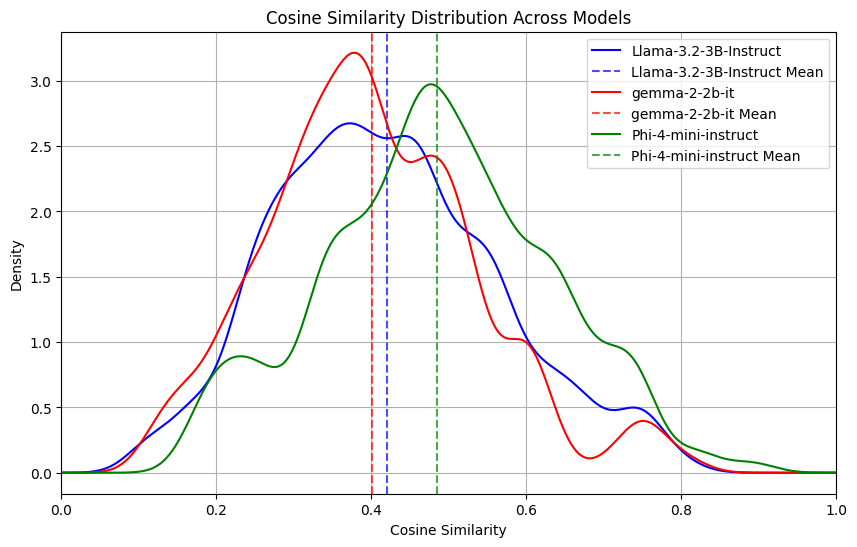

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

colors = ["blue", "red", "green"]

# Define file paths
files = {
    "Llama-3.2-3B-Instruct": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Llama-3.2-3B-Instruct.csv",
    "gemma-2-2b-it": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_gemma-2-2b-it.csv",
    "Phi-4-mini-instruct": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Phi-4-mini-instruct.csv"
}

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through files and plot cosine similarity as a line graph
for (model_name, file_path), color in zip(files.items(), colors):
      # Read CSV
      df = pd.read_csv(file_path)

      # Drop NaN values and extract cosine similarity values
      cosine_values = df["cosine_similarity"].dropna()

      # Compute the density estimate
      kde = gaussian_kde(cosine_values, bw_method=0.2)  # Bandwidth tuning for smoothness

      # Create x values for smooth plotting
      x_values = np.linspace(0, 1, 1000)  # Smooth range from 0 to 1
      y_values = kde(x_values)

      # Plot the density function
      plt.plot(x_values, y_values, label=model_name, color=color)

      # Compute mean and plot a dashed vertical line
      mean_value = cosine_values.mean()
      plt.axvline(mean_value, linestyle="dashed", alpha=0.7, label=f"{model_name} Mean", color=color)

# Graph settings
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Cosine Similarity Distribution Across Models")
plt.xlim(0, 1)  # Set x-axis range from 0 to 1
plt.legend()  # Show legend for models
plt.grid(True)

# Show the plot
plt.show()

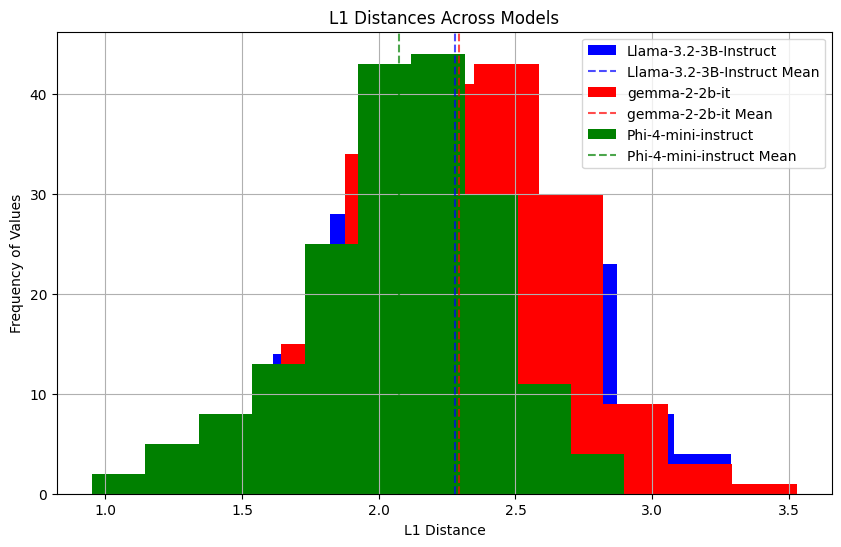

In [6]:
colors = ["blue", "red", "green"]

# Define file paths
files = {
    "Llama-3.2-3B-Instruct": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Llama-3.2-3B-Instruct.csv",
    "gemma-2-2b-it": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_gemma-2-2b-it.csv",
    "Phi-4-mini-instruct": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Phi-4-mini-instruct.csv"
}

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through files and plot cosine similarity as a line graph
for (model_name, file_path), color in zip(files.items(), colors):
      # Read CSV
      df = pd.read_csv(file_path)

      # Drop NaN values and extract L1 distances
      L1_values = df["L1_distance"].dropna()

      # Plot the density function
      plt.hist(L1_values, label=model_name, color = color)

      # Compute mean and plot a dashed vertical line
      mean_value = L1_values.mean()
      plt.axvline(mean_value, linestyle="dashed", alpha=0.7, label=f"{model_name} Mean", color=color)

# Graph settings
plt.xlabel("L1 Distance")
plt.ylabel("Frequency of Values")
plt.title("L1 Distances Across Models")
plt.legend()  # Show legend for models
plt.grid(True)

# Show the plot
plt.show()

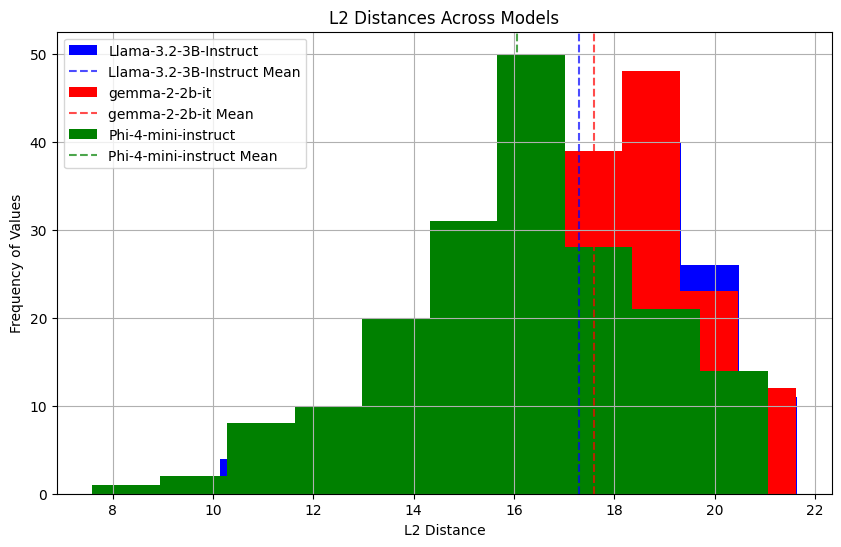

In [7]:
colors = ["blue", "red", "green"]

# Define file paths
files = {
    "Llama-3.2-3B-Instruct": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Llama-3.2-3B-Instruct.csv",
    "gemma-2-2b-it": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_gemma-2-2b-it.csv",
    "Phi-4-mini-instruct": "/content/drive/MyDrive/BIOINFO 201/Project_W25/results/pred_results_Phi-4-mini-instruct.csv"
}


# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through files and plot cosine similarity as a line graph
for (model_name, file_path), color in zip(files.items(), colors):
      # Read CSV
      df = pd.read_csv(file_path)

      # Drop NaN values and extract L1 distances
      L1_values = df["L2_distance"].dropna()

      # Plot the density function
      plt.hist(L1_values, label=model_name, color = color)

      # Compute mean and plot a dashed vertical line
      mean_value = L1_values.mean()
      plt.axvline(mean_value, linestyle="dashed", alpha=0.7, label=f"{model_name} Mean", color=color)

# Graph settings
plt.xlabel("L2 Distance")
plt.ylabel("Frequency of Values")
plt.title("L2 Distances Across Models")
plt.legend()  # Show legend for models
plt.grid(True)

# Show the plot
plt.show()